In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dc

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

In [3]:
df = pd.read_csv('data/GSPC.csv')

In [4]:
data = df[['Date', 'Close']]
data.head()

,Date,Close
0,1950-01-03,16.66
1,1950-01-04,16.85
2,1950-01-05,16.93
3,1950-01-06,16.98
4,1950-01-09,17.08


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

C:\Users\luiz_\AppData\Local\Temp\ipykernel_25952\459208422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


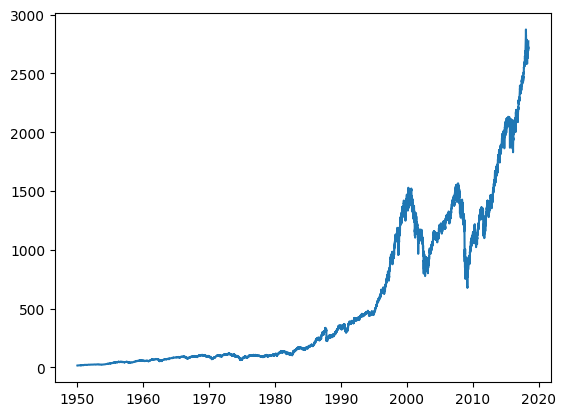

In [6]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data.loc[:, 'Date'], data.loc[:, 'Close']);

In [7]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1950-01-12,16.760000,17.090000,17.030001,17.080000,16.980000,16.930000,16.850000,16.66
1950-01-13,16.670000,16.760000,17.090000,17.030001,17.080000,16.980000,16.930000,16.85
1950-01-16,16.719999,16.670000,16.760000,17.090000,17.030001,17.080000,16.980000,16.93
1950-01-17,16.860001,16.719999,16.670000,16.760000,17.090000,17.030001,17.080000,16.98
1950-01-18,16.850000,16.860001,16.719999,16.670000,16.760000,17.090000,17.030001,17.08


In [8]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[  16.76    ,   17.09    ,   17.030001, ...,   16.93    ,
          16.85    ,   16.66    ],
       [  16.67    ,   16.76    ,   17.09    , ...,   16.98    ,
          16.93    ,   16.85    ],
       [  16.719999,   16.67    ,   16.76    , ...,   17.08    ,
          16.98    ,   16.93    ],
       ...,
       [2746.870117, 2734.620117, 2705.27002 , ..., 2721.330078,
        2727.76001 , 2733.290039],
       [2748.800049, 2746.870117, 2734.620117, ..., 2689.860107,
        2721.330078, 2727.76001 ],
       [2772.350098, 2748.800049, 2746.870117, ..., 2724.01001 ,
        2689.860107, 2721.330078]])

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99993698, -0.9997059 , -0.99974792, ..., -0.99981794,
        -0.99987396, -1.        ],
       [-1.        , -0.99993698, -0.9997059 , ..., -0.99978293,
        -0.99981794, -0.99986696],
       [-0.99996499, -1.        , -0.99993698, ..., -0.99971291,
        -0.99978293, -0.99981094],
       ...,
       [ 0.91177089,  0.90319306,  0.88264121, ...,  0.89388696,
         0.8983894 ,  0.90226204],
       [ 0.91312229,  0.91177089,  0.90319306, ...,  0.87185071,
         0.89388696,  0.89838975],
       [ 0.92961276,  0.91312229,  0.91177089, ...,  0.89576353,
         0.87185071,  0.89388733]])

In [10]:
shifted_df_as_np.shape

(17211, 8)

In [11]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((17211, 7), (17211,))

In [12]:
X = dc(np.flip(X, axis=1))
X

array([[-1.        , -0.99987396, -0.99981794, ..., -0.99971291,
        -0.99974792, -0.9997059 ],
       [-0.99986696, -0.99981794, -0.99978293, ..., -0.99974792,
        -0.9997059 , -0.99993698],
       [-0.99981094, -0.99978293, -0.99971291, ..., -0.9997059 ,
        -0.99993698, -1.        ],
       ...,
       [ 0.90226204,  0.8983894 ,  0.89388696, ...,  0.89576353,
         0.88264121,  0.90319306],
       [ 0.89838975,  0.89388696,  0.87185071, ...,  0.88264121,
         0.90319306,  0.91177089],
       [ 0.89388733,  0.87185071,  0.89576353, ...,  0.90319306,
         0.91177089,  0.91312229]])

In [13]:
split_index = int(len(X) * 0.90)

split_index

15489

In [14]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15489, 7), (1722, 7), (15489,), (1722,))

In [15]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

# Aqui o shape significa: (profundidade: 15489, linhas: 7, colunas: 1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15489, 7, 1), (1722, 7, 1), (15489, 1), (1722, 1))

In [16]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([15489, 7, 1]),
 torch.Size([1722, 7, 1]),
 torch.Size([15489, 1]),
 torch.Size([1722, 1]))

In [17]:
# Criando o objeto Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [18]:
from torch.utils.data import DataLoader

batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([4, 7, 1]) torch.Size([4, 1])


In [20]:
y_batch

tensor([[-0.9477],
        [-0.9465],
        [-0.3976],
        [-0.9954]], device='cuda:0')

In [21]:
x_batch

tensor([[[-0.9484],
         [-0.9473],
         [-0.9469],
         [-0.9465],
         [-0.9471],
         [-0.9472],
         [-0.9470]],

        [[-0.9474],
         [-0.9471],
         [-0.9470],
         [-0.9471],
         [-0.9471],
         [-0.9467],
         [-0.9465]],

        [[-0.3428],
         [-0.3505],
         [-0.3425],
         [-0.3309],
         [-0.3335],
         [-0.3460],
         [-0.3523]],

        [[-0.9950],
         [-0.9953],
         [-0.9955],
         [-0.9955],
         [-0.9954],
         [-0.9955],
         [-0.9954]]], device='cuda:0')

In [22]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [23]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [24]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [25]:
learning_rate = 0.01
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.018
Batch 200, Loss: 0.001
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000
Batch 700, Loss: 0.000
Batch 800, Loss: 0.000
Batch 900, Loss: 0.000
Batch 1000, Loss: 0.000
Batch 1100, Loss: 0.000
Batch 1200, Loss: 0.000
Batch 1300, Loss: 0.000
Batch 1400, Loss: 0.000
Batch 1500, Loss: 0.000
Batch 1600, Loss: 0.000
Batch 1700, Loss: 0.000
Batch 1800, Loss: 0.000
Batch 1900, Loss: 0.000
Batch 2000, Loss: 0.000
Batch 2100, Loss: 0.000
Batch 2200, Loss: 0.000
Batch 2300, Loss: 0.000
Batch 2400, Loss: 0.000
Batch 2500, Loss: 0.000
Batch 2600, Loss: 0.000
Batch 2700, Loss: 0.000
Batch 2800, Loss: 0.000
Batch 2900, Loss: 0.000
Batch 3000, Loss: 0.000
Batch 3100, Loss: 0.000
Batch 3200, Loss: 0.000
Batch 3300, Loss: 0.000
Batch 3400, Loss: 0.000
Batch 3500, Loss: 0.000
Batch 3600, Loss: 0.000
Batch 3700, Loss: 0.000
Batch 3800, Loss: 0.000

Val Loss: 0.018
***************************************************

Epoch: 2
Batch 100

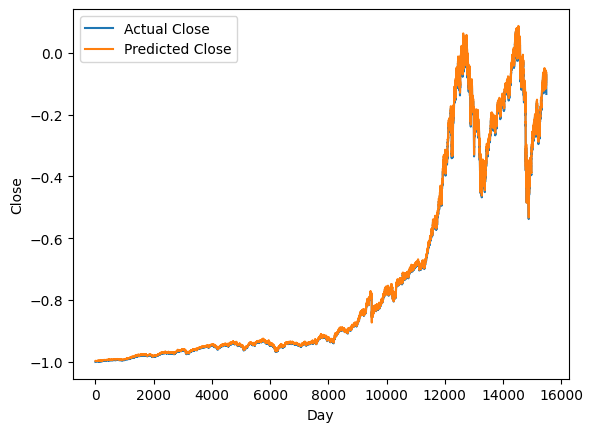

In [26]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [27]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  20.82869096,   20.31013141,   20.34341387, ..., 1310.88269877,
       1303.13207639, 1297.47856859])

In [28]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([  16.75997332,   16.67      ,   16.71996626, ..., 1292.28002401,
       1286.93994383, 1254.0500576 ])

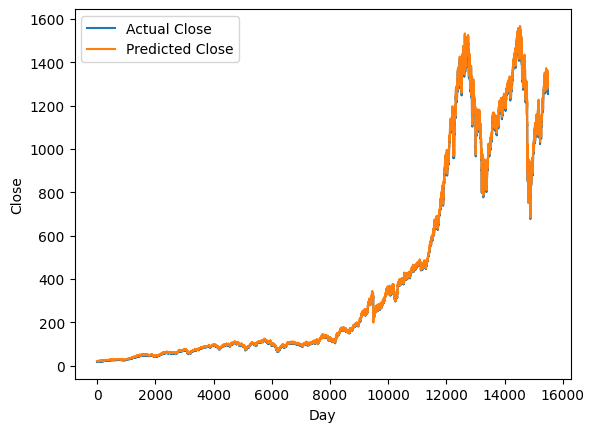

In [29]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [30]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([1266.16006591, 1269.70835133, 1213.20134207, ..., 2971.25291657,
       2982.51498808, 2983.48962807])

In [31]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([1260.33997553, 1200.06994085, 1199.38001065, ..., 2746.87010588,
       2748.80006331, 2772.35008941])

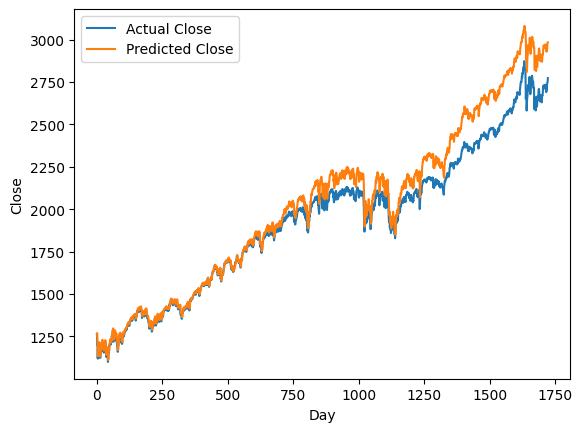

In [32]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()